# Hyperparameter Tuning of Metamodels
I think ...


Group members: 1

No. 1 -Definitions


Using he technique known as "Stealing"
-> Steal som lecture definition from Frank

Pros:
- 100% accurate
- Minimal work required
- Less energy consumption than GhatGPT
- (Major) If Damiano think it's bad slides, he critiques Frank and not you.

Cons:
- Need to remember to give credit -> Thank you Frank
- Need to be of a certain level of stupid to actually try to get away with such jokes.





### Metamodeling (according to Frank)
- Metamodeling is a simplified model created from a complex model
- The aim of metamodeling is to invest computational resources to develop fast
mathematical approximations of sophisticated, computationally demanding model

Design of Experiments in metamodeling
Objectives:
- Perturb the parameters in the physical/simulation model
- Estimate the sensitivity of the parameters (including interaction and square terms)
- Establish an empirical model between input and output
- Find the optimal settings given constraints
- Predict output while circumventing the physical model

## Problem
In an AHU with a cooling coil that cools down water

$$
\dot{T}_{ca} = -c1\dot{m}_{sa}(T_{ca}-T_{ha}) - c_2\frac{\dot{m}_{sa}^l}{1+(\frac{\dot{m}_{sa}}{\dot{m}_w})^l}(T_{ca}-T_{w})
$$

For MPC which prefers differentiability...
$$
c_2\frac{\dot{m}_{sa}^l}{1+(\frac{\dot{m}_{sa}}{\dot{m}_w})^l}(T_{ca}-T_{w})
$$

This term is a Real piece of work (SINGULARITY!!!!)


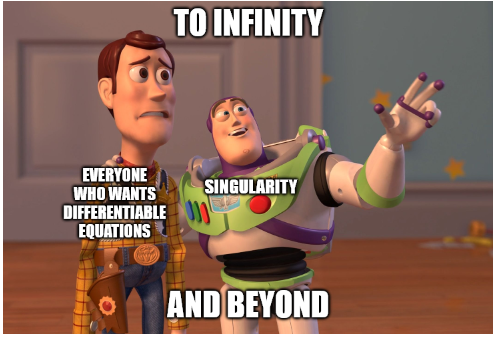

### We simplify the problem


$$
c_2\frac{\dot{m}_{sa}^l}{1+(\frac{\dot{m}_{sa}}{\dot{m}_w})^l}T_x
$$
Which we want on a form close to:
$$
c_2p(\dot{m}_{sa},\dot{m}_{w})^lT_x
$$

where


$ 6 <= \dot{m}_{sa} <= 11$

$ 0 <= \dot{m}_w <= 3$

$ 6 <= T_x <= 36$

That is differentiable!!









In [1]:
c2 = 3.9722
l = 0.6078
T_x = 13

Lower_bound_w = 0.001
upper_bound_w = 3

Lower_bound_sa =6
upper_bound_sa = 11

def non_linear(m_sa, m_w):

  return c2* m_sa**l*T_x/(1+(m_sa/m_w)**l)


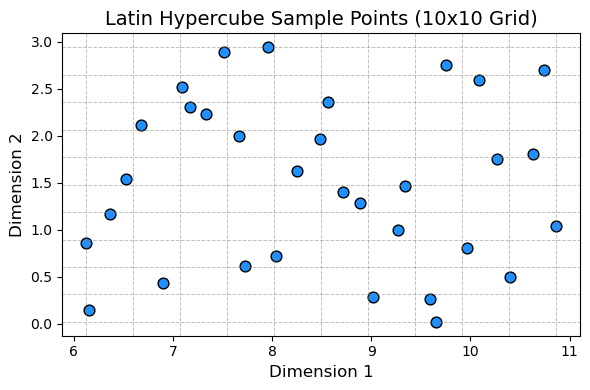

In [2]:
from scipy.stats import qmc
import numpy as np
import matplotlib.pyplot as plt

sampler = qmc.LatinHypercube(d=2)

sample = sampler.random(n=32)
l_bounds = [Lower_bound_sa,Lower_bound_w]
u_bounds = [upper_bound_sa,upper_bound_w]
scaled = qmc.scale(sample, l_bounds, u_bounds)




# Plot
plt.figure(figsize=(6, 4))
plt.scatter(scaled[:, 0], scaled[:, 1], color='dodgerblue', s=60, edgecolor='black')

# Add grid lines for 10x10 division
x_min, x_max = scaled[:, 0].min(), scaled[:, 0].max()
y_min, y_max = scaled[:, 1].min(), scaled[:, 1].max()

# Create 10 evenly spaced lines across the range
x_grid = np.linspace(x_min, x_max, 11)
y_grid = np.linspace(y_min, y_max, 11)

for x in x_grid:
    plt.axvline(x, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)
for y in y_grid:
    plt.axhline(y, color='gray', linestyle='--', linewidth=0.7, alpha=0.5)

# Labels and formatting
plt.title("Latin Hypercube Sample Points (10x10 Grid)", fontsize=14)
plt.xlabel("Dimension 1", fontsize=12)
plt.ylabel("Dimension 2", fontsize=12)
plt.grid(False)  # We already added custom grid lines
plt.tight_layout()
plt.show()


2.9431906798724814


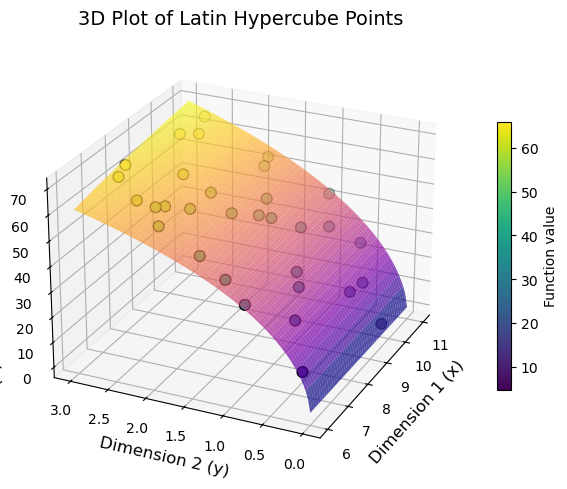

In [3]:
z = non_linear(scaled[:,0], scaled[:,1])
print(y)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

m_sa_t = np.linspace(Lower_bound_sa,upper_bound_sa,100)
m_w_t = np.linspace(Lower_bound_w, upper_bound_w, 100)
X,Y = np.meshgrid(m_sa_t, m_w_t)

Z = non_linear(X,Y)


sc = ax.scatter(scaled[:,0], scaled[:,1], z, c=z, cmap='viridis', s=60, edgecolor='black')

ax.set_title("3D Plot of Latin Hypercube Points", fontsize=14)
ax.set_xlabel("Dimension 1 (x)", fontsize=12)
ax.set_ylabel("Dimension 2 (y)", fontsize=12)
ax.set_zlabel("f(x, y) = sin(x) * cos(y)", fontsize=12)
ax.plot_surface(X, Y, Z, cmap='plasma', alpha=0.7)
ax.view_init(azim=-155, elev=25)


fig.colorbar(sc, ax=ax, shrink=0.6, label='Function value')
plt.tight_layout()
plt.show()

## Clemens' method for metamodelling garbage non-differentiable equations
(which also hopefully works with data)

We want to create an approximate function for our ugly function

$$
f(x,y) \approx \tilde{f}(x,y)\\
 \tilde{f}(x,y) = ∑_{i = 0}^N{C_ix^{p_i}y^{q_i}}
$$
Where $N$, $\textbf{p}$ and $\textbf{q}$ are hyperparameters.given Gthat you have $M$ samples of $x$ and $y$ that result in:
$$
z_i = f(x_i, y_i)
$$
Then $\textbf{p}$ and $\textbf{q}$ can be found using Grid search, and the optimal constant $C_i^*$, which is given by minimizing RMSE error

$$
C_{N+1}^* = min \sqrt{\frac{1}{M} \sum_{j = 0}^M (z_j- \tilde{f}(x_j,y_j) -C_{N+1}^*x_j^{p_{i+1}}y_j^{q_{i+1}})^2}
$$

$$
C_{N+1}^* = \frac{\sum_{j = 0}^M (z_j- \tilde{f}(x_j,y_j))*x_j^{p_{i+1}}y_j^{q_{i+1}}}{\sum_{j = 0}^M (x_j^{p_{i+1}}y_j^{q_{i+1}})^2}
$$



Where C is the parameter and p, q are they hyperparamteres. To see what are the most correct

In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

F = 11
p = np.linspace(0, 10, F)
q = np.linspace(0, 10, F)
print(p)
P,Q = np.meshgrid(p,q)

res = []
c = []
min_res = 99999
p_opt = 0
q_opt = 0
c_opt = 0
for x,y in zip(P.flatten(),Q.flatten()):
  pow = np.pow(scaled, [x,y])
  func  = pow[:,0]*pow[:,1]
  C_optimal = np.sum(z*func)/np.sum(np.pow(func,2))

  residual = np.sqrt(np.sum(np.pow(z-func*C_optimal,2))/len(z))

  if residual < min_res:
    min_res = residual
    p_opt, q_opt  = x,y
    c_opt = C_optimal

  res.append(residual)
  c.append(C_optimal)
print(f'C_optimal is {c_opt}')
print(f'q_optimal is {q_opt}')
print(f'p_optimal is {p_opt}')
print(f'The RMSE for the optimum is {min_res}')


r = np.array(res).reshape((F,F))
c = np.abs(np.array(c).reshape((F,F)))


fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]])
fig.add_trace(go.Surface(x=P, y=Q, z=r,
                         colorscale='Viridis', opacity=0.6,
                         name='Real Model Surface',
                         contours = {
                                    "z": {"show": True, "color": "black", "width": 2}},
                         colorbar=dict(title='Metamodel', x=0.5) ), row = 1, col = 1) # move further right))
fig.add_trace(go.Surface(x=P, y=Q, z=c,
                         colorscale='Viridis', opacity=0.6,
                         name='Absolute values of C',

                         colorbar=dict(title='C values(abs)', x=1.05) ), row = 1, col = 2) # move further right))

fig.update_layout(
    title='Interactive 3D Surface (Metamodel)',
    scene=dict(
        xaxis_title='p',
        yaxis_title='q',
        zaxis_title='res',
    ),
    width=1600,
    height=600
)

fig.show()



[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]
C_optimal is 26.943873257134854
q_optimal is 1.0
p_optimal is 0.0
The RMSE for the optimum is 10.567890502875128


In [5]:

def new_func(sa, w):
    C = c_opt
    p = p_opt
    q = q_opt
    l = 1
    return C * sa**(p*l) * w**(q*l) #* T_x * c2

# Define ranges
m_sa_t = np.linspace(Lower_bound_sa, upper_bound_sa, 100)
m_w_t = np.linspace(Lower_bound_w, upper_bound_w, 100)
X_n, Y_n = np.meshgrid(m_sa_t, m_w_t)
Z_n = new_func(X_n, Y_n)

# Interactive 3D surface plot
fig = go.Figure()

# Add your surface
fig.add_trace(go.Surface(x=X_n, y=Y_n, z=Z_n,
                         colorscale='Viridis', opacity=0.9,
                         name='Metamodel Surface',
                         colorbar=dict(title='Original', x=0.85))  # move to the right
                         )

fig.add_trace(go.Surface(x=X, y=Y, z=Z,
                         colorscale='Greys', opacity=0.2,
                         name='Real Model Surface',
                         contours = {
                                    "z": {"show": True, "color": "black", "width": 2}},
                         colorbar=dict(title='Metamodel', x=1.05) )) # move further right))



fig.update_layout(
    title='Interactive 3D Surface (Metamodel)',
    scene=dict(
        xaxis_title='sa',
        yaxis_title='w',
        zaxis_title='f(sa, w)',
    ),
    width=800,
    height=600
)

fig.show()

## Can we do it again???



In [6]:
from plotly.subplots import make_subplots

F = 11
p = np.linspace(0, 10, F)
q = np.linspace(0, 10, F)
P,Q = np.meshgrid(p,q)

res = []
c = []
min_res_2 = 99999
p_opt_2 = 0
q_opt_2 = 0
c_opt_2 = 0
z_local = z - new_func(scaled[:,0],scaled[:,1])
print(np.sqrt(np.sum(np.pow(z_local, 2))/len(z)))
for x,y in zip(P.flatten(),Q.flatten()):

  pow = np.pow(scaled, [x*l,y*l])
  func  = pow[:,0]*pow[:,1]*T_x*c2
  C_optimal = np.sum(z_local*func)/np.sum(np.pow(func,2))
  #print(C_optimal)

  residual = np.sqrt(np.sum(np.pow(z_local-func*C_optimal,2))/len(z_local))

  if residual < min_res_2:
    min_res_2 = residual
    p_opt_2, q_opt_2  = x,y
    c_opt_2 = C_optimal

  res.append(residual)
  c.append(C_optimal)
print(f'C_optimal is {c_opt_2}')
print(f'q_optimal is {q_opt_2}')
print(f'p_optimal is {p_opt_2}')
print(f'The RMSE for the optimum is {min_res_2}')
print(f'improvement from previous metamodel is {100-100*min_res_2/min_res} %')


c = np.abs(np.array(c).reshape((F,F)))
r = np.array(res).reshape((F,F))

fig = make_subplots(
    rows=1, cols=2,
    specs=[[{'type': 'surface'}, {'type': 'surface'}]])
fig.add_trace(go.Surface(x=P, y=Q, z=r,
                         colorscale='Viridis', opacity=0.6,
                         name='Real Model Surface',
                         contours = {
                                    "z": {"show": True, "color": "black", "width": 2}},
                         colorbar=dict(title='Metamodel', x=0.5) ), row = 1, col = 1) # move further right))
fig.add_trace(go.Surface(x=P, y=Q, z=c,
                         colorscale='Viridis', opacity=0.6,
                         name='Absolute values of C',

                         colorbar=dict(title='C values(abs)', x=1.05) ), row = 1, col = 2) # move further right))

fig.update_layout(
    title='Interactive 3D Surface (Metamodel)',
    scene=dict(
        xaxis_title='p',
        yaxis_title='q',
        zaxis_title='res',
    ),
    width=1600,
    height=600
)

fig.show()



10.567890502875128
C_optimal is 0.0018212569880361707
q_optimal is 0.0
p_optimal is 3.0
The RMSE for the optimum is 9.331928337388733
improvement from previous metamodel is 11.695448255734064 %


In [7]:
from dataclasses import dataclass
funcY_List = []
@dataclass
class funcydunkey:
  C_opt:float
  p: int
  q: int


  def return_val(self, sa, w):
    return self.C_opt * sa**(self.p) * w**(self.q)
def add_funcy_wunkey_bobble_dunkey(f):
    funcY_List.append(f)

def return_func_val(sa, w):
  s = sum([f.return_val(sa, w) for f in funcY_List])
  return s

for k in range(7):
  F = 11
  p = np.linspace(0, 10, F)
  q = np.linspace(0, 10, F)
  P,Q = np.meshgrid(p,q)

  res = []
  c = []
  min_res_2 = 99999
  p_opt_2 = 0
  q_opt_2 = 0
  c_opt_2 = 0


  current_func = return_func_val(scaled[:,0], scaled[:,1])
  z_local = z - current_func
  print(np.sqrt(np.sum(np.pow(z_local, 2))/len(z)))
  for x,y in zip(P.flatten(),Q.flatten()):

    pow = np.pow(scaled, [x,y])
    func  = pow[:,0]*pow[:,1]
    C_optimal = np.sum(z_local*func)/np.sum(np.pow(func,2))
    #print(C_optimal)

    residual = np.sqrt(np.sum(np.pow(z_local-func*C_optimal,2))/len(z_local))

    if residual < min_res_2:
      min_res_2 = residual
      p_opt_2, q_opt_2  = x,y
      c_opt_2 = C_optimal

    res.append(residual)
    c.append(C_optimal)
  print(f'C_optimal is {c_opt_2}')
  print(f'q_optimal is {q_opt_2}')
  print(f'p_optimal is {p_opt_2}')
  print(f'The RMSE for the optimum is {min_res_2}')
  print(f'improvement from previous metamodel is {100-100*min_res_2/min_res} %')

  c = np.abs(np.array(c).reshape((F,F)))
  r = np.array(res).reshape((F,F))

  fig = make_subplots(
      rows=1, cols=2,
      specs=[[{'type': 'surface'}, {'type': 'surface'}]])
  fig.add_trace(go.Surface(x=P, y=Q, z=r,
                          colorscale='Viridis', opacity=0.6,
                          name='Real Model Surface',
                          contours = {
                                      "z": {"show": True, "color": "black", "width": 2}},
                          colorbar=dict(title='Metamodel', x=0.5) ), row = 1, col = 1) # move further right))
  fig.add_trace(go.Surface(x=P, y=Q, z=c,
                          colorscale='Viridis', opacity=0.6,
                          name='Absolute values of C',

                          colorbar=dict(title='C values(abs)', x=1.05) ), row = 1, col = 2) # move further right))

  fig.update_layout(
      title='Interactive 3D Surface (Metamodel)',
      scene=dict(
          xaxis_title='p',
          yaxis_title='q',
          zaxis_title='res',
      ),
      width=1600,
      height=600
  )

  fig.show()
  fffy = funcydunkey(C_opt = c_opt_2, p = p_opt_2, q = q_opt_2)
  add_funcy_wunkey_bobble_dunkey(fffy)



48.005238092397335
C_optimal is 26.943873257134854
q_optimal is 1.0
p_optimal is 0.0
The RMSE for the optimum is 10.567890502875128
improvement from previous metamodel is 1.4210854715202004e-14 %


10.567890502875128
C_optimal is 0.06345056960275292
q_optimal is 0.0
p_optimal is 2.0
The RMSE for the optimum is 9.334411008849788
improvement from previous metamodel is 11.671955663145411 %


9.334411008849786
C_optimal is -0.09453138241094554
q_optimal is 5.0
p_optimal is 0.0
The RMSE for the optimum is 6.138630710748509
improvement from previous metamodel is 41.912430781919845 %


6.138630710748509
C_optimal is 4.026867626402879
q_optimal is 0.0
p_optimal is 0.0
The RMSE for the optimum is 4.63326279444337
improvement from previous metamodel is 56.15716501620799 %


4.633262794443369
C_optimal is -0.2391824953522009
q_optimal is 3.0
p_optimal is 0.0
The RMSE for the optimum is 3.9225061116131825
improvement from previous metamodel is 62.8827899896766 %


3.922506111613182
C_optimal is 1.6316706871815438
q_optimal is 0.0
p_optimal is 0.0
The RMSE for the optimum is 3.5670302724024188
improvement from previous metamodel is 66.24652506162926 %


3.5670302724024197
C_optimal is -0.28649264731819757
q_optimal is 2.0
p_optimal is 0.0
The RMSE for the optimum is 3.3727083835293694
improvement from previous metamodel is 68.0853205035406 %


In [8]:



m_sa_t = np.linspace(Lower_bound_sa, upper_bound_sa, 100)
m_w_t = np.linspace(Lower_bound_w, upper_bound_w, 100)
X_n, Y_n = np.meshgrid(m_sa_t, m_w_t)
Z_n = return_func_val(X_n, Y_n)

# Interactive 3D surface plot
fig = go.Figure()

# Add your surface
fig.add_trace(go.Surface(x=X_n, y=Y_n, z=Z_n,
                         colorscale='Viridis', opacity=0.9,

                         colorbar=dict(title='Original', x=0.85))  # move to the right
                         )

fig.add_trace(go.Surface(x=X, y=Y, z=Z,
                         colorscale='Greys', opacity=0.2,
                         name='Real Model Surface',
                         contours = {
                                    "z": {"show": True, "color": "black", "width": 2}},
                         colorbar=dict(title='Metamodel', x=1.05) )) # move further right))



fig.update_layout(
    title='Interactive 3D Surface (Metamodel)',
    scene=dict(
        xaxis_title='sa',
        yaxis_title='w',
        zaxis_title='f(sa, w)',
    ),
    width=800,
    height=600
)

fig.show()


## Turns out, there exist good models.


## Laguerre Polynials

$ xy''+(1-x)y'+ny=0,\ y=y(x)$


Stuff can be approximated using:

$ f(x) \approx \sum_{n=0}^NC_nL_n^{(\alpha)}(x)$




In [9]:
sa = scaled[:,0]
w = scaled[:,1]
z = z
deg = 3
deg_x = deg
deg_y = deg

from numpy.polynomial.laguerre import lagvander2d, laggrid2d

# Create basis matrix manually

Phi = lagvander2d(sa, w, [deg_x, deg_y])
print(np.array(Phi).shape)
coeffs, *_ = np.linalg.lstsq(Phi, z, rcond=None)
print(coeffs)
C_ = coeffs.reshape(deg_x + 1, deg_y + 1)
print(C_.shape)
X_, Y_ = np.meshgrid(m_sa_t, m_w_t)



(32, 16)
[ 9.97320406e+01 -1.04231478e+03  1.58585575e+03 -1.21646278e+03
  2.18066461e+01 -3.23752274e+02  4.99620020e+02 -3.80168542e+02
  6.12554842e+00 -8.40872291e+01  1.29556952e+02 -9.81526001e+01
  1.18589860e+00 -1.53030933e+01  2.35892358e+01 -1.77682054e+01]
(4, 4)


In [10]:
Zz= laggrid2d(m_sa_t, m_w_t, C_)





In [11]:
import numpy as np
from numpy.polynomial.laguerre import lagvander2d

def laguerre_rmse(x, y, z, coeffs, deg_x, deg_y):
    """
    Compute RMSE between Laguerre polynomial model and observed z-values.

    Parameters
    ----------
    x, y : array-like
        Sample coordinates (1D arrays of same length)
    z : array-like
        Observed target values
    coeffs : array-like
        Flattened Laguerre coefficients from lstsq fit
    deg_x, deg_y : int
        Polynomial degrees in x and y directions

    Returns
    -------
    rmse : float
        Root mean square error between model and data
    z_pred : ndarray
        Predicted z-values from the Laguerre model
    """
    # Build design matrix
    Phi = lagvander2d(x, y, [deg_x, deg_y])  # shape (n_samples, (deg_x+1)*(deg_y+1))

    # Predict model values
    z_pred = Phi @ coeffs  # vectorized prediction

    # Compute RMSE
    rmse = np.sqrt(np.mean((z - z_pred)**2))
    return rmse, z_pred

10.0


C:\Users\PhD\AppData\Local\Temp\ipykernel_1072\1388523677.py:25: UserWarning:

Adding colorbar to a different Figure <Figure size 700x500 with 2 Axes> than <Figure size 700x500 with 2 Axes> which fig.colorbar is called on.



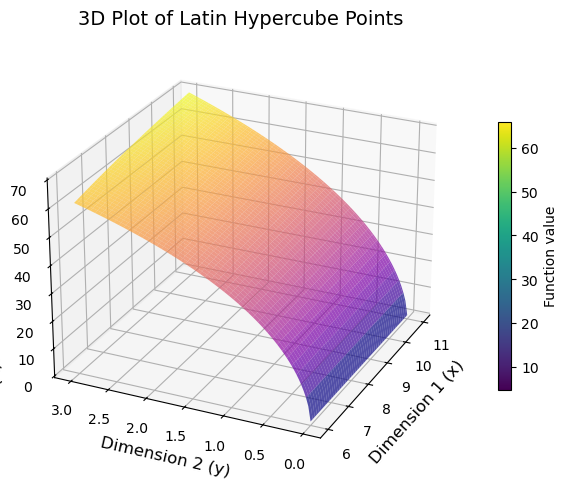

In [12]:
z = non_linear(scaled[:,0], scaled[:,1])
print(y)
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111, projection='3d')

m_sa_t = np.linspace(Lower_bound_sa,upper_bound_sa,100)
m_w_t = np.linspace(Lower_bound_w, upper_bound_w, 100)
X_,Y_ = np.meshgrid(m_sa_t, m_w_t)

Z_ = non_linear(X_,Y_)




#sc = ax.scatter(scaled[:,0], scaled[:,1], z, c=z, cmap='viridis', s=60, edgecolor='black')

ax.set_title("3D Plot of Latin Hypercube Points", fontsize=14)
ax.set_xlabel("Dimension 1 (x)", fontsize=12)
ax.set_ylabel("Dimension 2 (y)", fontsize=12)
ax.set_zlabel("f(x, y) = sin(x) * cos(y)", fontsize=12)
ax.plot_surface(X_, Y_, Z_, cmap='plasma', alpha=0.7)
ax.view_init(azim=-155, elev=25)


fig.colorbar(sc, ax=ax, shrink=0.6, label='Function value')
plt.tight_layout()
plt.show()

In [13]:
import plotly.graph_objects as go
fig = go.Figure()

# Add fitted Laguerre surface
fig.add_trace(go.Surface(
    x=X_n,
    y=Y_n,
    z=Zz.T,
    colorscale='Viridis',
    opacity=0.9,
    name='Laguerre Fit'
))

fig.add_trace(go.Surface(x=X_n, y=Y_n, z=Z,
                         colorscale='Greys', opacity=0.3,
                         name='Real Model Surface',
                         contours = {
                                    "z": {"show": True, "color": "black", "width": 2}},
                         colorbar=dict(title='Metamodel', x=1.25) )) # move further right))

fig.update_layout(
    title='2D Laguerre Polynomial Fit (Interactive)',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='f(x, y)',
    ),
    width=900,
    height=700
)



fig.show()


rmse, z_pred = laguerre_rmse(sa, w, z, coeffs, deg_x, deg_y)
print(f"RMSE of Laguerre model: {rmse:.6f}")

RMSE of Laguerre model: 0.577534


In [14]:
from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=2)

l_bounds = [Lower_bound_sa, Lower_bound_w]
u_bounds = [upper_bound_sa, upper_bound_w]

latin_hc = [qmc.scale(sampler.random(n=64), l_bounds, u_bounds) for i in range(5)]

zs = [non_linear(u[:,0], u[:,1]) for u in latin_hc]

for i in range(len(zs)):
    sa = latin_hc[i][:,0]
    w = latin_hc[i][:,1]
    z = zs[i]
    rmse, z_pred = laguerre_rmse(sa, w, z, coeffs, deg_x, deg_y)
    print(f"RMSE of Laguerre model: {rmse:.6f}")



RMSE of Laguerre model: 1.725811
RMSE of Laguerre model: 1.649888
RMSE of Laguerre model: 1.714325
RMSE of Laguerre model: 1.936046
RMSE of Laguerre model: 1.796755


In [15]:
sa = scaled[:,0]
w = scaled[:,1]
z = z
deg = 3
deg_x = deg
deg_y = deg

from numpy.polynomial.laguerre import lagvander2d, laggrid2d

# Create basis matrix manually

Phi = lagvander2d(sa, w, [deg_x, deg_y])
print(np.array(Phi).shape)
coeffs, *_ = np.linalg.lstsq(Phi, z, rcond=None)
print(coeffs)
C_ = coeffs.reshape(deg_x + 1, deg_y + 1)
print(C_.shape)
X_, Y_ = np.meshgrid(m_sa_t, m_w_t)



Zz= laggrid2d(m_sa_t, m_w_t, C_)


import plotly.graph_objects as go
fig = go.Figure()

# Add fitted Laguerre surface
fig.add_trace(go.Surface(
    x=X_n,
    y=Y_n,
    z=Zz.T,
    colorscale='Viridis',
    opacity=0.9,
    name='Laguerre Fit'
))

fig.add_trace(go.Surface(x=X_n, y=Y_n, z=Z,
                         colorscale='Greys', opacity=0.3,
                         name='Real Model Surface',
                         contours = {
                                    "z": {"show": True, "color": "black", "width": 2}},
                         colorbar=dict(title='Metamodel', x=1.25) )) # move further right))

fig.update_layout(
    title='2D Laguerre Polynomial Fit (Interactive)',
    scene=dict(
        xaxis_title='x',
        yaxis_title='y',
        zaxis_title='f(x, y)',
    ),
    width=900,
    height=700
)



fig.show()


rmse, z_pred = laguerre_rmse(sa, w, z, coeffs, deg_x, deg_y)
print(f"RMSE of Laguerre model:on original data: {rmse:.6f}")

from scipy.stats import qmc

sampler = qmc.LatinHypercube(d=2)

l_bounds = [Lower_bound_sa, Lower_bound_w]
u_bounds = [upper_bound_sa, upper_bound_w]

latin_hc = [qmc.scale(sampler.random(n=32), l_bounds, u_bounds) for i in range(5)]

zs = [non_linear(u[:,0], u[:,1]) for u in latin_hc]

for i in range(len(zs)):
    sa = latin_hc[i][:,0]
    w = latin_hc[i][:,1]
    z = zs[i]
    rmse, z_pred = laguerre_rmse(sa, w, z, coeffs, deg_x, deg_y)
    print(f"RMSE of Laguerre model: {rmse:.6f}")



(32, 16)


LinAlgError: Incompatible dimensions